# Import Packages

In [90]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import ast
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from jcopml.plot import plot_confusion_matrix
from sklearn.metrics import classification_report

# Load Preprocessed Dataset

In [50]:
df = pd.read_csv("data_prep.csv", usecols=['stemmed','sentimen'], encoding='latin-1')
df

,stemmed,sentimen
0,"['jangkau', 'hubung', 'kavling', 'tanah', 'jua...",Netral
1,"['akwowakoawkaow', 'kos', 'gawe', 'jakarta', '...",Netral
2,"['damage', 'parah', 'banget', 'nder', 'take', ...",Netral
3,"['goodbener', 'ajak', 'warga', 'dki', 'jakarta...",Netral
4,"['delapan', 'dukung', 'anies', 'butuh', 'jakar...",Netral
...,...,...
95,"['saking', 'otak', 'gagas', 'ngibul', 'ngarang...",Netral
96,"['cari', 'tanah', 'kavling', 'bangun', 'kebun'...",Netral
97,"['march', 'jakarta', 'indonesia', 'tickets', '...",Netral
98,"['kenneth', 'perintah', 'pusat', 'coba', 'jali...",Netral


# Data Preparation

## Encoding Categorical Values

In [51]:
le = preprocessing.LabelEncoder()
df['sentimen']=le.fit_transform(df['sentimen'])

## Combining Fractions of Words into One Sentence

In [52]:
def join_text_list(texts):
    texts = ast.literal_eval(texts)
    return ' '.join([text for text in texts])

df['stemmed'] = df['stemmed'].apply(join_text_list)
df

,stemmed,sentimen
0,jangkau hubung kavling tanah jual murah kavlin...,1
1,akwowakoawkaow kos gawe jakarta wae,1
2,damage parah banget nder take all potong harga...,1
3,goodbener ajak warga dki jakarta gapai berkah ...,1
4,delapan dukung anies butuh jakarta perintah pusat,1
...,...,...
95,saking otak gagas ngibul ngarang cerita muka t...,1
96,cari tanah kavling bangun kebun buah jangkau h...,1
97,march jakarta indonesia tickets info,1
98,kenneth perintah pusat coba jalin komunikasi k...,1


## Pembobotan TF-IDF

In [53]:
max_features = 200

# calc TF vector
count = CountVectorizer(max_features=max_features)
TF_vector = count.fit_transform(df['stemmed'])

# normalize TF vector
normalized_TF_vector = normalize(TF_vector, norm='l1', axis=1)

# calc IDF
tfidf = TfidfVectorizer(max_features=max_features, ngram_range=(1,3), smooth_idf=False)
tfs = tfidf.fit_transform(df['stemmed'])
IDF_vector = tfidf.idf_

# hitung TF x IDF sehingga dihasilkan TFIDF matrix / vector
tfidf_mat = normalized_TF_vector.multiply(IDF_vector).toarray()
df['stemmed'] = tfidf_mat

# Data Splitting 

Mari kita pisahkan kumpulan data menjadi kumpulan pelatihan dan pengujian, yang akan dipilih secara acak semu untuk membuat pemisahan 80-20%. Kita akan menggunakan set pelatihan untuk melatih model dan melakukan beberapa pengoptimalan. Kita akan menggunakan set pengujian, yang akan bertindak sebagai data yang tidak terlihat, untuk menilai kinerja model.

Saat menggunakan metode ini untuk pembelajaran mesin, selalu berhati-hatilah dalam menggunakan set pengujian untuk membuat model. Kebocoran data adalah masalah umum yang dapat mengakibatkan overfitting.

In [70]:
#Mendefinisikan x and y
X = df.drop(['sentimen'],axis=1)
y = df['sentimen']

# pembagian data (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0, stratify = y)

In [71]:
y_train = y_train.ravel() 
y_test = y_test.values.ravel() 

ravel digunakan untuk membersihkan set pengujian untuk menghindari pesan peringatan di masa mendatang

# Pemodelan Random Forest

Pemodelan Random Forest dimulai dengan setting parameter yang ada. Berikut adalah parameter yang akan kita atur dalam pemodelan ini:

max_depth: Pemisahan maksimum untuk semua pohon di hutan. 

bootstrap: Indikator apakah kita ingin menggunakan sampel bootstrap atau tidak saat membangun pohon.

max_features: Jumlah maksimum fitur yang akan digunakan dalam pemisahan simpul — perbedaan utama antara bagging tree dan random forest. Biasanya, pemodelan memiliki nilai yang kurang dari p, di mana p adalah semua fitur dalam kumpulan data.

criterion: Ini adalah metrik yang digunakan untuk menilai kriteria penghentian untuk pohon keputusan.

Setelah kita membuat instance model kita, kita akan melanjutkan dan setting parameter kita.

In [72]:
clf = RandomForestClassifier(random_state=0)

Atur random state untuk reproduktifitas

## Hyperparameters Optimization

Memanfaatkan fungsionalitas GridSearchCV, mari buat kamus dengan parameter yang ingin kita optimalkan untuk membuat model terbaik untuk data kita. Menyetel n_jobs ke 3 memberitahu pencarian grid untuk menjalankan tiga pekerjaan secara paralel, mengurangi waktu yang dibutuhkan fungsi untuk menghitung parameter terbaik.

Ini akan membantu mengatur parameter yang akan kita gunakan untuk menyetel satu parameter terakhir: jumlah pohon di hutan kita.

In [73]:
import time

start = time.time()
np.random.seed(0)

param_dist = {'max_depth': [2, 3, 4],
              'bootstrap': [True],
              'max_features': ['sqrt', 'log2'],
              'criterion': ['gini', 'entropy']}

cv_rf = GridSearchCV(clf, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 3)

cv_rf.fit(X_train, y_train)
print('Best Parameters using grid search: \n', 
      cv_rf.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

C:\Users\taqiy\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


Best Parameters using grid search: 
 {'bootstrap': True, 'criterion': 'gini', 'max_depth': 2, 'max_features': 'sqrt'}
Time taken in grid search:  13.30


In [74]:
# Set parameter terbaik grid search 
clf.set_params(criterion = 'gini',
                  max_features = 'sqrt', 
                  max_depth = 2)

RandomForestClassifier(max_depth=2, max_features='sqrt', random_state=0)

## Out of Bag Error Rate

Fitur lain dari random forest adalah error rate out-of-bag (OOB). Karena hanya dua pertiga dari data yang digunakan untuk melatih setiap pohon saat membangun hutan, sepertiga dari data yang tidak terlihat dapat digunakan dengan cara yang menguntungkan metrik akurasi kami tanpa menjadi mahal secara komputasi seperti validasi silang.

Seperti diuraikan di bawah ini, saat menghitung OOB, dua parameter harus diubah. Dengan memanfaatkan for-loop di banyak ukuran hutan, kita dapat menghitung tingkat kesalahan OOB dan menggunakannya untuk menilai berapa banyak pohon yang sesuai untuk model kita.

In [75]:
clf.set_params(warm_start=True, 
                  oob_score=True)

min_estimators = 5
max_estimators = 50

error_rate = {}

for i in range(min_estimators, max_estimators + 1):
    clf.set_params(n_estimators=i)
    clf.fit(X_train, y_train)

    oob_error = 1 - clf.oob_score_
    error_rate[i] = oob_error

C:\Users\taqiy\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\taqiy\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:549: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\taqiy\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\taqiy\AppData\Roaming\Python\Python39\site-packages\sklearn\ensemble\_forest.py:549: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\taqiy\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid fea

C:\Users\taqiy\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\taqiy\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\taqiy\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\taqiy\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\taqiy\AppData\Roaming\Python\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with f

Text(0.5, 1.0, 'OOB Error Rate Across various Forest sizes \n(From 200 to 1000 trees)')

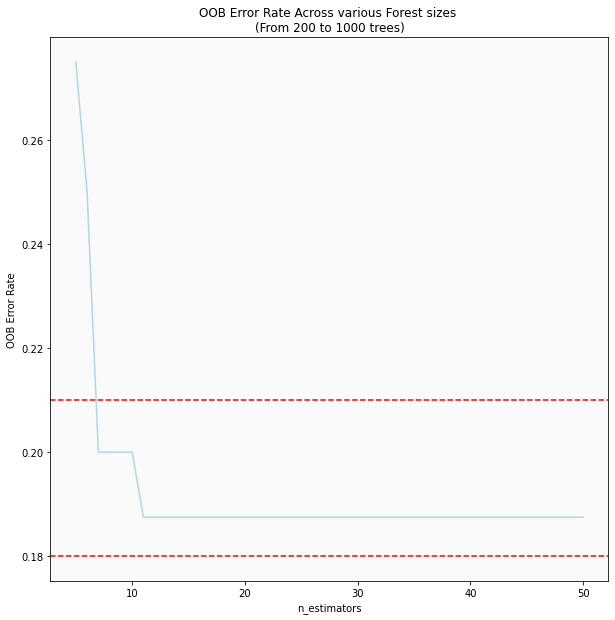

In [78]:
# Convert dictionary ke pandas series untuk memudahkan plotting
oob_series = pd.Series(error_rate)

fig, ax = plt.subplots(figsize=(10, 10))

ax.set_facecolor('#fafafa')

oob_series.plot(kind='line',
                color = 'lightblue')
plt.axhline(0.18, 
            color='red',
           linestyle='--')
plt.axhline(0.21, 
            color='red',
           linestyle='--')
plt.xlabel('n_estimators')
plt.ylabel('OOB Error Rate')
plt.title('OOB Error Rate Across various Forest sizes \n(From 200 to 1000 trees)')

Tingkat kesalahan OOB mulai berosilasi di sekitar 10 pohon, jadi kita akan melanjutkan dan menggunakan 10 pohon di hutan. Menggunakan pandas series objek, kita dapat dengan mudah menemukan tingkat kesalahan OOB untuk penaksir sebagai berikut:

In [80]:
print('OOB Error rate for 10 trees is: {0:.5f}'.format(oob_series[10]))

OOB Error rate for 10 trees is: 0.20000


## Training Model

Agar metodologi ini berfungsi, kita akan mengatur jumlah pohon yang dihitung menggunakan tingkat kesalahan OOB, dan menghapus parameter warm_start dan oob_score. Bersamaan dengan menyertakan parameter bootstrap.

In [81]:
clf.set_params(n_estimators=10,
                  bootstrap = True,
                  warm_start=False, 
                  oob_score=False)
clf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features='sqrt', n_estimators=10,
                       random_state=0)

## Variable Importance

Selanjutnya melihat pentingnya fitur model dan menggunakan fungsi untuk menampilkan pentingnya variabel kita dalam urutan menurun.

In [82]:
def variable_importance(fit):
    try:
        if not hasattr(fit, 'fit'):
            return print("'{0}' is not an instantiated model from scikit-learn".format(fit)) 

        if not vars(fit)["estimators_"]:
            return print("Model tidak terlatih.")
    except KeyError:
        print("Model yang dimasukkan tidak mengandung 'estimators_' attribute.")

    importances = fit.feature_importances_
    indices = np.argsort(importances)[::-1]
    return {'importance': importances,
            'index': indices}

In [83]:
var_imp_rf = variable_importance(clf)

importances_rf = var_imp_rf['importance']

indices_rf = var_imp_rf['index']

In [84]:
def print_var_importance(importance, indices, name_index):
    print("Feature ranking:")

    for f in range(0, indices.shape[0]):
        i = f
        print("{0}. The feature '{1}' has a Mean Decrease in Impurity of {2:.5f}"
              .format(f + 1,
                      names_index[indices[i]],
                      importance[indices[f]]))

In [85]:
names_index = ['stemmed']

In [86]:
print_var_importance(importances_rf, indices_rf, names_index)

Feature ranking:
1. The feature 'stemmed' has a Mean Decrease in Impurity of 1.00000


# Evaluasi Model Random Forest

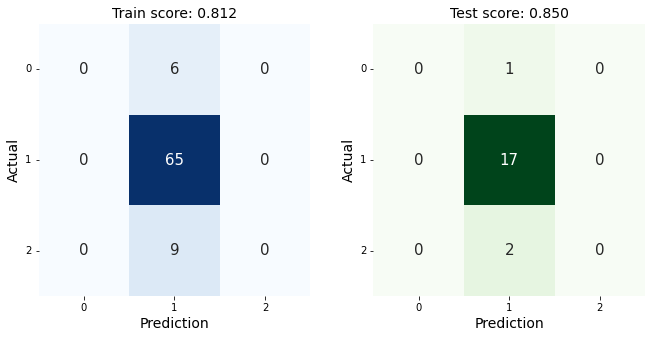

In [91]:
clf = RandomForestClassifier(bootstrap=True, n_estimators=10, 
                             max_depth = 2, max_features='sqrt', random_state=0)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Melihat evaluasi model menggunakan confusion matrix
plot_confusion_matrix(X_train, y_train, X_test, y_test, clf)

In [92]:
# Melihat hasil klasifikasi
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.85      1.00      0.92        17
           2       0.00      0.00      0.00         2

    accuracy                           0.85        20
   macro avg       0.28      0.33      0.31        20
weighted avg       0.72      0.85      0.78        20



C:\Users\taqiy\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\taqiy\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\taqiy\AppData\Roaming\Python\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
